#Downloading Data

In [53]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 2.41 s (started: 2025-05-27 14:10:06 +00:00)


In [54]:
import pandas as pd
from google.colab import drive

time: 306 µs (started: 2025-05-27 14:10:09 +00:00)


In [55]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.83 s (started: 2025-05-27 14:10:09 +00:00)


In [56]:
save_path = '/content/drive/My Drive/DS Final Project/Subject Classification/1K_manual_even.csv'
df = pd.read_csv(save_path)
df.head()

,Subject_new,body_clean,topic_embed,topic_label,manual_label
0,CarSmart Price Quote,kevin hyatt br date mon aug br carsmart vehic...,0,Meeting Feedback,Meeting / Scheduling
1,FW Kiodex Premeeting ROOM CHANGE TO EB,robbie pateder project manager working tech re...,0,Meeting Feedback,Meeting / Scheduling
2,eThink About It,join cindy olson executive vice president huma...,0,Meeting Feedback,Other / Uncategorized
3,Training for Sabrae,like set half day training sessions sabrae zaj...,0,Meeting Feedback,HR / Personal
4,updated,original message woods trevor sent tuesday oct...,0,Meeting Feedback,Other / Uncategorized


time: 151 ms (started: 2025-05-27 14:10:12 +00:00)


#Model

In [57]:
# Show number of unique topics
print("Number of unique topics:", df['manual_label'].nunique())

# Show topic counts
topic_counts = df['manual_label'].value_counts().sort_index()
print("\nEmails per topic:")
print(topic_counts)


Number of unique topics: 9

Emails per topic:
manual_label
Announcement / Info          102
Finance / Budget             137
HR / Personal                138
Legal / Compliance           146
Meeting / Scheduling         137
Other / Uncategorized        119
Project Update               136
Report / Summary             117
Support / Technical Issue    139
Name: count, dtype: int64
time: 3.27 ms (started: 2025-05-27 14:10:12 +00:00)


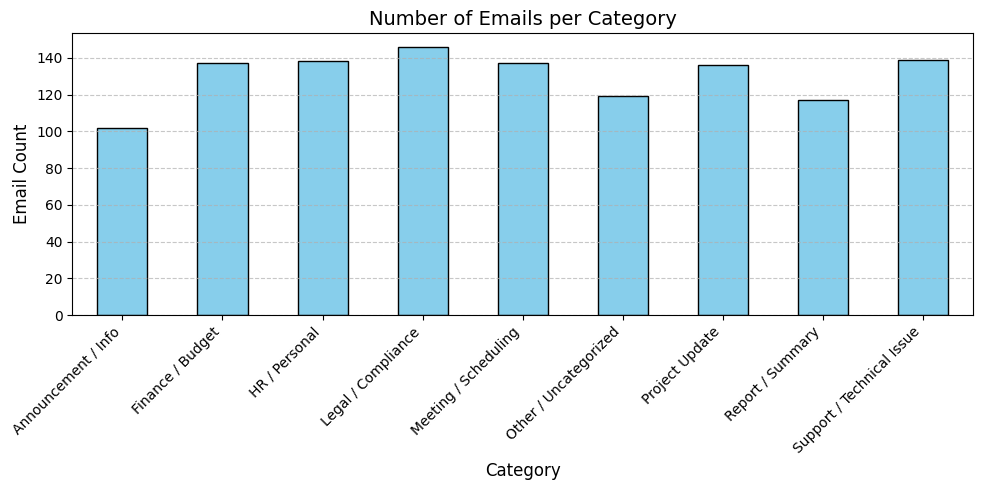

time: 372 ms (started: 2025-05-27 14:10:12 +00:00)


In [58]:
import matplotlib.pyplot as plt

# Count the number of emails per topic
topic_counts = df['manual_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Emails per Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Email Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##download

In [59]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

time: 568 µs (started: 2025-05-27 14:10:12 +00:00)


In [60]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

time: 1.3 ms (started: 2025-05-27 14:10:12 +00:00)


##Encoding

In [61]:
#df['text'] = df['Subject_new'].astype(str) + ' ' + df['body_clean'].astype(str)

# 1. Combine subject and content into one text field
#df['text'] = df['subject'].astype(str) + ' ' + df['content'].astype(str)

df['text'] = (
    df['Subject_new'].fillna('') + ' ' +
    df['body_clean'].fillna('') + ' '
)

def inject_topic_tag(text):
    txt = text.lower()

    if any(kw in txt for kw in ['invoice', 'budget', 'cost center', 'expense', 'finance', 'payment']):
        return '[FINANCE] ' + text

    if any(kw in txt for kw in ['meeting', 'calendar', 'schedule', 'reschedule', 'invite']):
        return '[SCHEDULING] ' + text

    if any(kw in txt for kw in ['promotion', 'vacation', 'birthday', 'family', 'congratulations', 'thank you']):
        return '[HR_PERSONAL] ' + text

    if any(kw in txt for kw in ['nda', 'contract', 'compliance', 'legal', 'policy', 'regulation']):
        return '[LEGAL] ' + text

    if any(kw in txt for kw in ['issue', 'bug', 'support', 'error', 'ticket', 'technical']):
        return '[SUPPORT] ' + text

    if any(kw in txt for kw in ['progress', 'milestone', 'status update', 'timeline']):
        return '[PROJECT] ' + text

    if any(kw in txt for kw in ['summary', 'recap', 'overview', 'executive summary']):
        return '[SUMMARY] ' + text

    if any(kw in txt for kw in ['announcement', 'important update', 'notification']):
        return '[ANNOUNCEMENT] ' + text

    if any(kw in txt for kw in ['attached', 'see document', 'spreadsheet', 'pdf', 'ppt']):
        return '[DOCUMENT] ' + text

    return '[OTHER] ' + text

# Apply injection
df['text'] = df['text'].apply(inject_topic_tag)


time: 85.7 ms (started: 2025-05-27 14:10:12 +00:00)


In [62]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['manual_label'])

# Save this to decode predictions later
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Announcement / Info': np.int64(0), 'Finance / Budget': np.int64(1), 'HR / Personal': np.int64(2), 'Legal / Compliance': np.int64(3), 'Meeting / Scheduling': np.int64(4), 'Other / Uncategorized': np.int64(5), 'Project Update': np.int64(6), 'Report / Summary': np.int64(7), 'Support / Technical Issue': np.int64(8)}
time: 6.39 ms (started: 2025-05-27 14:10:12 +00:00)


##Split

In [63]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)

time: 5.94 ms (started: 2025-05-27 14:10:12 +00:00)


##Tokenize

In [64]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


time: 13.2 s (started: 2025-05-27 14:10:12 +00:00)


##Dataset Class

In [65]:
import torch
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # tokenizer outputs
        self.labels = labels        # your numeric labels from LabelEncoder

    def __len__(self):
        return len(self.labels)  # how many samples in total

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }


time: 1.76 ms (started: 2025-05-27 14:10:26 +00:00)


In [66]:
train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)

time: 371 µs (started: 2025-05-27 14:10:26 +00:00)


##Bert

In [67]:
!pip install -U transformers

time: 5.74 s (started: 2025-05-27 14:10:26 +00:00)


In [68]:
# from transformers import BertForSequenceClassification

# num_labels = len(label_encoder.classes_)  # should be 10 for your case

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels=num_labels
# )

from transformers import BertConfig, BertForSequenceClassification

num_labels = len(label_encoder.classes_)  # should match your 7 selected tags

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    hidden_dropout_prob=0.3,              # ⬅️ Increase dropout
    attention_probs_dropout_prob=0.3      # ⬅️ Dropout in attention layers
)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=config
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 380 ms (started: 2025-05-27 14:10:31 +00:00)


In [69]:
# from transformers import BertForSequenceClassification
# import torch
# from torch.optim import AdamW

# # Define number of labels from your label encoder
# num_labels = len(label_encoder.classes_)

# # Load model
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# # Optimizer
# optimizer = AdamW(model.parameters(), lr=2e-5)

# # Loss function (BERT already calculates loss internally)
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

from transformers import BertForSequenceClassification
import torch
from torch.optim import AdamW

# Define number of labels from your label encoder
num_labels = len(label_encoder.classes_)

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    hidden_dropout_prob=0.4,              # ⬅️ Increase dropout
    attention_probs_dropout_prob=0.4      # ⬅️ Dropout in attention layers
)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=config
)

# Move model to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 390 ms (started: 2025-05-27 14:10:32 +00:00)


In [70]:
from torch.utils.data import DataLoader

# Use batch size = 16 as defined earlier
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


time: 957 µs (started: 2025-05-27 14:10:32 +00:00)


In [71]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Get class weights based on your label distribution
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),  # Make sure train_labels is a list or numpy array
    y=train_labels
)

# Create tensor for loss function
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define custom loss function using the weights
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

time: 2.6 ms (started: 2025-05-27 14:10:32 +00:00)


In [72]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):  # Set your number of epochs
    print(f"\n🔁 Epoch {epoch + 1}")

    # === TRAIN ===
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)  # ✅ use this instead
        train_loss += loss.item()

        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += loss_fn(outputs.logits, labels).item()

            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"✅ Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")




🔁 Epoch 1


100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


✅ Train Loss: 2.2238 | Train Acc: 0.1271
🧪 Val   Loss: 2.1927 | Val   Acc: 0.1447

🔁 Epoch 2


100%|██████████| 59/59 [00:38<00:00,  1.55it/s]


✅ Train Loss: 2.1958 | Train Acc: 0.1410
🧪 Val   Loss: 2.1676 | Val   Acc: 0.1191

🔁 Epoch 3


100%|██████████| 59/59 [00:38<00:00,  1.52it/s]


✅ Train Loss: 2.1362 | Train Acc: 0.1806
🧪 Val   Loss: 2.1315 | Val   Acc: 0.1489

🔁 Epoch 4


100%|██████████| 59/59 [00:38<00:00,  1.53it/s]


✅ Train Loss: 2.1213 | Train Acc: 0.1838
🧪 Val   Loss: 2.0778 | Val   Acc: 0.1745

🔁 Epoch 5


100%|██████████| 59/59 [00:38<00:00,  1.54it/s]


✅ Train Loss: 2.0766 | Train Acc: 0.2073
🧪 Val   Loss: 2.0314 | Val   Acc: 0.2213
time: 3min 30s (started: 2025-05-27 14:10:32 +00:00)


##Metrics

In [73]:
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

time: 3.14 s (started: 2025-05-27 14:14:03 +00:00)


In [74]:
from sklearn.metrics import classification_report

# Decode back to label names
target_names = label_encoder.inverse_transform(sorted(set(all_labels)))

print(classification_report(all_labels, all_preds, target_names=target_names))

                           precision    recall  f1-score   support

      Announcement / Info       0.13      0.20      0.16        20
         Finance / Budget       0.00      0.00      0.00        28
            HR / Personal       0.00      0.00      0.00        28
       Legal / Compliance       0.34      0.52      0.41        29
     Meeting / Scheduling       0.20      0.07      0.11        28
    Other / Uncategorized       0.14      0.38      0.21        24
           Project Update       0.00      0.00      0.00        27
         Report / Summary       0.34      0.87      0.49        23
Support / Technical Issue       0.33      0.07      0.12        28

                 accuracy                           0.22       235
                macro avg       0.17      0.23      0.17       235
             weighted avg       0.16      0.22      0.16       235

time: 44.2 ms (started: 2025-05-27 14:14:06 +00:00)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


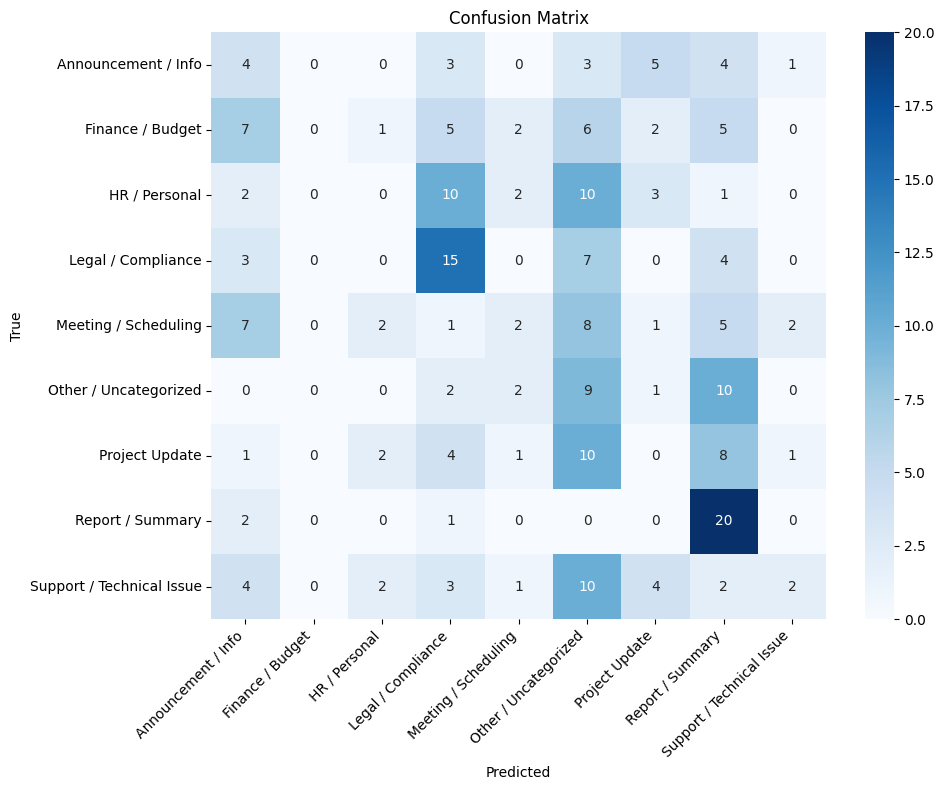

time: 669 ms (started: 2025-05-27 14:14:06 +00:00)


In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [76]:
import pandas as pd

# Rebuild the label decoding map
inv_label_map = {v: k for k, v in label_mapping.items()}

# Convert numeric labels to strings
true_labels_text = [inv_label_map[i] for i in val_labels]
pred_labels_text = [inv_label_map[i] for i in val_preds]

# Build evaluation DataFrame
df_eval = pd.DataFrame({
    'text': val_texts,
    'true_label': true_labels_text,
    'pred_label': pred_labels_text
})

# Save to CSV
df_eval.to_csv("enron_notlabel_eval_results.csv", index=False)


time: 13.4 ms (started: 2025-05-27 14:14:06 +00:00)


In [77]:
from google.colab import files
files.download("enron_notlabel_eval_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 5.52 ms (started: 2025-05-27 14:14:06 +00:00)


#Improve

In [ ]:
# Step 1: Load model prediction results
df_errors = pd.read_csv("model_eval_results.csv")

# Step 2: Keep only misclassified samples
df_misclassified = df_errors[df_errors['true_label'] != df_errors['pred_label']]

# Step 3: Merge into your labeled training DataFrame
# You need to map text to original df to recover label numbers
df_misclassified = df_misclassified.merge(
    df[['text', 'label']], on='text', how='left'
)

# Step 4: Append misclassified rows to original df
df_boosted = pd.concat([df, df_misclassified], ignore_index=True)

# ✅ Optional: Shuffle
df_boosted = df_boosted.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 🔁 From here, continue with df_boosted instead of df:
# encoding, train/val split, tokenizer, model training, etc.


time: 42.1 ms (started: 2025-05-27 13:17:44 +00:00)


##Encoding

In [ ]:
# 1. Combine subject and content into one text field
#df['text'] = df['subject'].astype(str) + ' ' + df['content'].astype(str)

df_boosted['text'] = (
    df_boosted['subject'].fillna('') + ' ' +
    df_boosted['content'].fillna('') + ' ' +
    df_boosted['x_folder'].fillna('') + ' ' +
    df_boosted['x_filename'].fillna('')
)

def inject_tags(row):
    text = row['text'].lower()

    # EMPLOYMENT cues
    if any(keyword in text for keyword in ['resume', 'cv', 'position', 'apply', 'hiring', 'job', 'interview']):
        return '[EMPLOYMENT] ' + row['text']

    # PERSONAL cues
    elif any(keyword in text for keyword in ['thank you', 'congratulations', 'happy birthday', 'good to see you', 'see you soon']):
        return '[PERSONAL] ' + row['text']

    # LOGISTICS cues
    elif any(keyword in text for keyword in ['meeting', 'schedule', 'call', 'join us', 'calendar', 'time']):
        return '[LOGISTICS] ' + row['text']

    # DOCUMENT COLLABORATION cues
    elif any(keyword in text for keyword in ['attached', 'document', 'review', 'spreadsheet', 'draft']):
        return '[DOCUMENT] ' + row['text']

    # Default: no tag
    else:
        return row['text']

df_boosted['text'] = df_boosted.apply(inject_tags, axis=1)


time: 71.1 ms (started: 2025-05-27 13:17:45 +00:00)


In [ ]:
# 2. Encode the target (coarse_genre)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_boosted['label'] = label_encoder.fit_transform(df_boosted['coarse_genre'])

# 3. Save the mapping (to use later for decoding predictions)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)


{'Company Business / Strategy': np.int64(0), 'Document Collaboration': np.int64(1), 'Employment': np.int64(2), 'Logistics': np.int64(3), 'Personal': np.int64(4), nan: np.int64(5)}
time: 1.54 ms (started: 2025-05-27 13:17:45 +00:00)


##Split

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_boosted['text'].tolist(), df_boosted['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_boosted['label']
)

time: 3.59 ms (started: 2025-05-27 13:17:45 +00:00)


##Train

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(8):  # Adjust number of epochs if needed
    print(f"\n🔁 Epoch {epoch + 1}")

    # === TRAINING ===
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)  # ✅ using class-weighted loss
        train_loss += loss.item()

        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_preds = all_preds
    val_labels = all_labels

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"✅ Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")



🔁 Epoch 1


100%|██████████| 83/83 [00:54<00:00,  1.53it/s]


✅ Train Loss: 1.0413 | Train Acc: 0.7591
🧪 Val   Loss: 1.4550 | Val   Acc: 0.5347

🔁 Epoch 2


100%|██████████| 83/83 [00:55<00:00,  1.48it/s]


✅ Train Loss: 0.9647 | Train Acc: 0.7871
🧪 Val   Loss: 1.4274 | Val   Acc: 0.5921

🔁 Epoch 3


100%|██████████| 83/83 [00:57<00:00,  1.45it/s]


✅ Train Loss: 0.9220 | Train Acc: 0.8227
🧪 Val   Loss: 1.5478 | Val   Acc: 0.5740

🔁 Epoch 4


100%|██████████| 83/83 [00:57<00:00,  1.43it/s]


✅ Train Loss: 0.8753 | Train Acc: 0.8326
🧪 Val   Loss: 1.4658 | Val   Acc: 0.5740

🔁 Epoch 5


100%|██████████| 83/83 [00:58<00:00,  1.43it/s]


✅ Train Loss: 0.8660 | Train Acc: 0.8644
🧪 Val   Loss: 1.4941 | Val   Acc: 0.6133

🔁 Epoch 6


100%|██████████| 83/83 [00:58<00:00,  1.43it/s]


✅ Train Loss: 0.8537 | Train Acc: 0.8530
🧪 Val   Loss: 1.4338 | Val   Acc: 0.6254

🔁 Epoch 7


100%|██████████| 83/83 [00:58<00:00,  1.42it/s]


✅ Train Loss: 0.8272 | Train Acc: 0.8947
🧪 Val   Loss: 1.4425 | Val   Acc: 0.6284

🔁 Epoch 8


100%|██████████| 83/83 [00:57<00:00,  1.43it/s]


✅ Train Loss: 0.8238 | Train Acc: 0.8902
🧪 Val   Loss: 1.4509 | Val   Acc: 0.6344
time: 8min 15s (started: 2025-05-27 13:17:45 +00:00)


##Metrics

In [ ]:
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


time: 4.54 s (started: 2025-05-27 13:26:00 +00:00)


In [ ]:
from sklearn.metrics import classification_report

# Get label IDs sorted as they appear in label_encoder
label_ids = list(range(len(label_encoder.classes_)))
target_names = label_encoder.inverse_transform(label_ids)

# Print report
print(classification_report(all_labels, all_preds, target_names=target_names))


ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

time: 62.5 ms (started: 2025-05-27 13:26:05 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
df['coarse_genre'].value_counts()

In [ ]:
import pandas as pd

# Rebuild the label decoding map
inv_label_map = {v: k for k, v in label_mapping.items()}

# Convert numeric labels to strings
true_labels_text = [inv_label_map[i] for i in val_labels]
pred_labels_text = [inv_label_map[i] for i in val_preds]

# Build evaluation DataFrame
df_eval = pd.DataFrame({
    'text': val_texts,
    'true_label': true_labels_text,
    'pred_label': pred_labels_text
})

# Save to CSV
df_eval.to_csv("model_eval_results.csv", index=False)


In [ ]:
from google.colab import files
files.download("model_eval_results.csv")